In [155]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
from torchvision import transforms as T
import scipy.io
from PIL import Image
import numpy as np
pa_100k_group_order = [7,8,13,14,15,16,17,18,19,20,21,22,23,24,25,9,10,11,12,1,2,3,0,4,5,6]
pa_100k_num_in_group = [2, 6, 6, 1, 4, 3, 1, 3]


class PA100KDataset(Dataset):
    def __init__(self, root_dir, transforms, split, use_multitask=False):
        self.annotations = scipy.io.loadmat("./data/PA-100K/annotation.mat")
        self.file_paths = self.annotations[f"{split}_images_name"]
        self.labels = self.annotations[f"{split}_label"]
        self.root_dir = root_dir
        self.transforms = transforms
        self.use_multitask = use_multitask
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = self.file_paths[index][0][0]
        image = Image.open(os.path.join(self.root_dir, image_path))
        if self.transforms:
            image = self.transforms(image)
        if self.use_multitask:
            group_label = []
            label = self.labels[index]

            for group in range(len(pa_100k_num_in_group)):
                group_num = pa_100k_num_in_group[group]
                start_index = pa_100k_group_order[sum(pa_100k_num_in_group[:group])]
                end_index = pa_100k_group_order[sum(pa_100k_num_in_group[:group]) + group_num - 1]
                group_label.append(np.argmax(self.labels[index][start_index:end_index+1]))
            return image, group_label

        label = self.labels[index]
        return image, label
        

In [58]:
import time

import numpy as np
from easydict import EasyDict
import torch


def get_pedestrian_metrics(gt_label, preds_probs, threshold=0.5, index=None, cfg=None):
    """
    index: evaluated label index
    """
    pred_label = preds_probs > threshold

    eps = 1e-20
    result = EasyDict()

    if index is not None:
        pred_label = pred_label[:, index]
        gt_label = gt_label[:, index]

    ###############################
    # label metrics
    # TP + FN
    gt_pos = np.sum((gt_label == 1), axis=0).astype(float)
    # TN + FP
    gt_neg = np.sum((gt_label == 0), axis=0).astype(float)
    # TP
    true_pos = np.sum((gt_label == 1) * (pred_label == 1), axis=0).astype(float)
    # TN
    true_neg = np.sum((gt_label == 0) * (pred_label == 0), axis=0).astype(float)
    # FP
    false_pos = np.sum(((gt_label == 0) * (pred_label == 1)), axis=0).astype(float)
    # FN
    false_neg = np.sum(((gt_label == 1) * (pred_label == 0)), axis=0).astype(float)

    label_pos_recall = 1.0 * true_pos / (gt_pos + eps)  # true positive
    label_neg_recall = 1.0 * true_neg / (gt_neg + eps)  # true negative
    # mean accuracy
    label_ma = (label_pos_recall + label_neg_recall) / 2

    result.label_pos_recall = label_pos_recall
    result.label_neg_recall = label_neg_recall
    result.label_prec = true_pos / (true_pos + false_pos + eps)
    result.label_acc = true_pos / (true_pos + false_pos + false_neg + eps)
    result.label_f1 = 2 * result.label_prec * result.label_pos_recall / (
            result.label_prec + result.label_pos_recall + eps)

    result.label_ma = label_ma
    result.ma = np.mean(label_ma)

    ################
    # instance metrics
    gt_pos = np.sum((gt_label == 1), axis=1).astype(float)
    true_pos = np.sum((pred_label == 1), axis=1).astype(float)
    # true positive
    intersect_pos = np.sum((gt_label == 1) * (pred_label == 1), axis=1).astype(float)
    # IOU
    union_pos = np.sum(((gt_label == 1) + (pred_label == 1)), axis=1).astype(float)

    instance_acc = intersect_pos / (union_pos + eps)
    class_acc = instance_acc.copy()
    
    instance_prec = intersect_pos / (true_pos + eps)
    instance_recall = intersect_pos / (gt_pos + eps)
    instance_f1 = 2 * instance_prec * instance_recall / (instance_prec + instance_recall + eps)

    instance_acc = np.mean(instance_acc)
    instance_prec = np.mean(instance_prec)
    instance_recall = np.mean(instance_recall)
    # instance_f1 = np.mean(instance_f1)
    instance_f1 = 2 * instance_prec * instance_recall / (instance_prec + instance_recall + eps)

    result.instance_acc = instance_acc
    result.instance_prec = instance_prec
    result.instance_recall = instance_recall
    result.instance_f1 = instance_f1

    result.error_num, result.fn_num, result.fp_num = false_pos + false_neg, false_neg, false_pos

    return result, class_acc

In [156]:
from tqdm import tqdm

def evaluate(cfg, model, val_loader, device, epoch=0, best_acc=None):
        # Validation
    model.eval()  # Set the model to evaluation mode

    preds_probs = []
    gt_list = []

    with torch.no_grad():
        for (inputs, gt_label) in tqdm(val_loader, total=len(val_loader)):
            # Forward pass
            # gt_label = gt_label.cuda()
            # gt_list.append(gt_label.cpu().numpy())
            if cfg["use_multi_task"]:
                all_one_hot = []
                for n, gt in enumerate(gt_label):
                    one_hot_vector = torch.nn.functional.one_hot(gt, num_classes=cfg['num_per_group'][n])
                    all_one_hot.append(one_hot_vector)
                gt_label = torch.cat(all_one_hot, dim=1)
                gt_list.append(gt_label.cpu().numpy())
                outputs = model(inputs.to(device))
                probs = []
                for n, output in enumerate(outputs):
                    probs.append(output.sigmoid())
                
                probs = torch.cat(outputs, dim=1)
                # probs = probs.view(probs[0], -1)

                preds_probs.append(probs.cpu().numpy())
            else:
                gt_label = gt_label.cuda()
                gt_list.append(gt_label.cpu().numpy())
                outputs = model(inputs.to(device))
                probs = outputs.sigmoid()
                preds_probs.append(probs.cpu().numpy())
            
        gt_label = np.concatenate(gt_list, axis=0)
        preds_probs = np.concatenate(preds_probs, axis=0)

        val_results, ins_acc = get_pedestrian_metrics(gt_label, preds_probs)
        mean_results = (val_results.ma + val_results.instance_acc + val_results.instance_prec + val_results.instance_recall + val_results.instance_f1) / 5
        
        print(f'Epoch [{epoch+1}/{cfg["num_epochs"]}] - ' \
            f'mA: {val_results.ma:.4f} - InsAcc: {val_results.instance_acc} - InsPrec: {val_results.instance_prec} - ' \
            f'InsRecall: {val_results.instance_recall} - InsF1: {val_results.instance_f1} - mean results: {mean_results}')
        return ins_acc, mean_results, (gt_label, preds_probs) 

In [157]:
from dataset import build_test_loader
from models import PARModel
import yaml

config = yaml.load(open("./configs/baseline_pa100k.yaml", 'r'), Loader=yaml.Loader)
model = PARModel(config=config).to(device=torch.device("cuda"))


Position interpolate for blocks.0.attn.relative_position_bias_table from 47x47 to 27x27
Original positions = [-25.71657400763066, -24.47183280815386, -23.239416919381693, -22.01920429724265, -20.811074106134168, -19.614906706956507, -18.430583645265077, -17.2579876395401, -16.09700256957241, -14.947513464964274, -13.809406493744058, -12.68256895109365, -11.56688924818748, -10.462256901142071, -9.368562520075011, -8.285697798272247, -7.213555501462659, -6.152029457198832, -5.101014544342974, -4.060406682656948, -3.030102822495381, -2.0100009346008303, -1, 0, 1, 2.0100009346008303, 3.030102822495381, 4.060406682656948, 5.101014544342974, 6.152029457198832, 7.213555501462659, 8.285697798272247, 9.368562520075011, 10.462256901142071, 11.56688924818748, 12.68256895109365, 13.809406493744058, 14.947513464964274, 16.09700256957241, 17.2579876395401, 18.430583645265077, 19.614906706956507, 20.811074106134168, 22.01920429724265, 23.239416919381693, 24.47183280815386, 25.71657400763066]
Target p

/media/s24gb1/90a7e21c-edf4-4782-a0eb-731b73c521c2/Vietnamese_local_LLM/envBE/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [158]:
state_dict = torch.load("./checkpoint/model_best.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [159]:
test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_dataset = PA100KDataset("./data/PA-100K/release_data", test_transforms, "test")
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)


In [160]:
class_acc, mean_res, (gt_labels, pred_probs) = evaluate(config, model, test_loader, torch.device("cuda"), epoch=0, best_acc=None)

100%|██████████| 40/40 [01:08<00:00,  1.70s/it]

Epoch [1/3] - mA: 0.8382 - InsAcc: 0.8269693831168832 - InsPrec: 0.8903938095238096 - InsRecall: 0.9054337698412699 - InsF1: 0.897850810249283 - mean results: 0.8717625281925674


In [78]:
sorted_indices = np.argsort(class_acc)

In [124]:
sorted_indices[:20]

array([8031, 6754, 7068, 8108, 6084, 8230, 7408, 4884,  853, 5527, 5617,
       9487, 9082, 2015, 2277, 3109, 7719, 1929,  986, 2181])

In [148]:
image, label = test_loader.dataset.__getitem__(2277)

092278.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


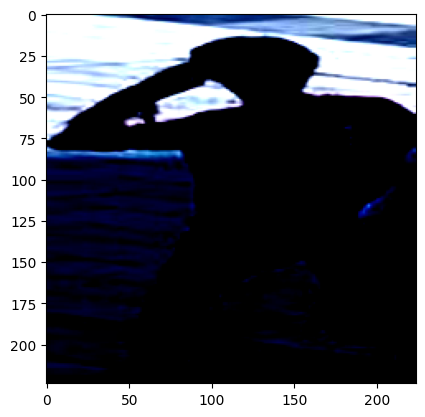

In [99]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))

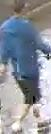

In [149]:
from PIL import Image

Image.open("./data/PA-100K/release_data/092278.jpg")

In [150]:
pred = model(image.unsqueeze(0).to(torch.device("cuda"))).sigmoid() > 0.5

In [151]:
pred = pred.cpu().numpy()

In [152]:
label

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0], dtype=uint8)

In [153]:
annotations = scipy.io.loadmat("./data/PA-100K/annotation.mat")

In [164]:
for idx, ann in enumerate(annotations['attributes']):
    print(ann[0])

['Female']
['AgeOver60']
['Age18-60']
['AgeLess18']
['Front']
['Side']
['Back']
['Hat']
['Glasses']
['HandBag']
['ShoulderBag']
['Backpack']
['HoldObjectsInFront']
['ShortSleeve']
['LongSleeve']
['UpperStride']
['UpperLogo']
['UpperPlaid']
['UpperSplice']
['LowerStripe']
['LowerPattern']
['LongCoat']
['Trousers']
['Shorts']
['Skirt&Dress']
['boots']


In [170]:
gt_labels

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [172]:
pred = pred_probs > 0.5

In [173]:
gt_labels == pred

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

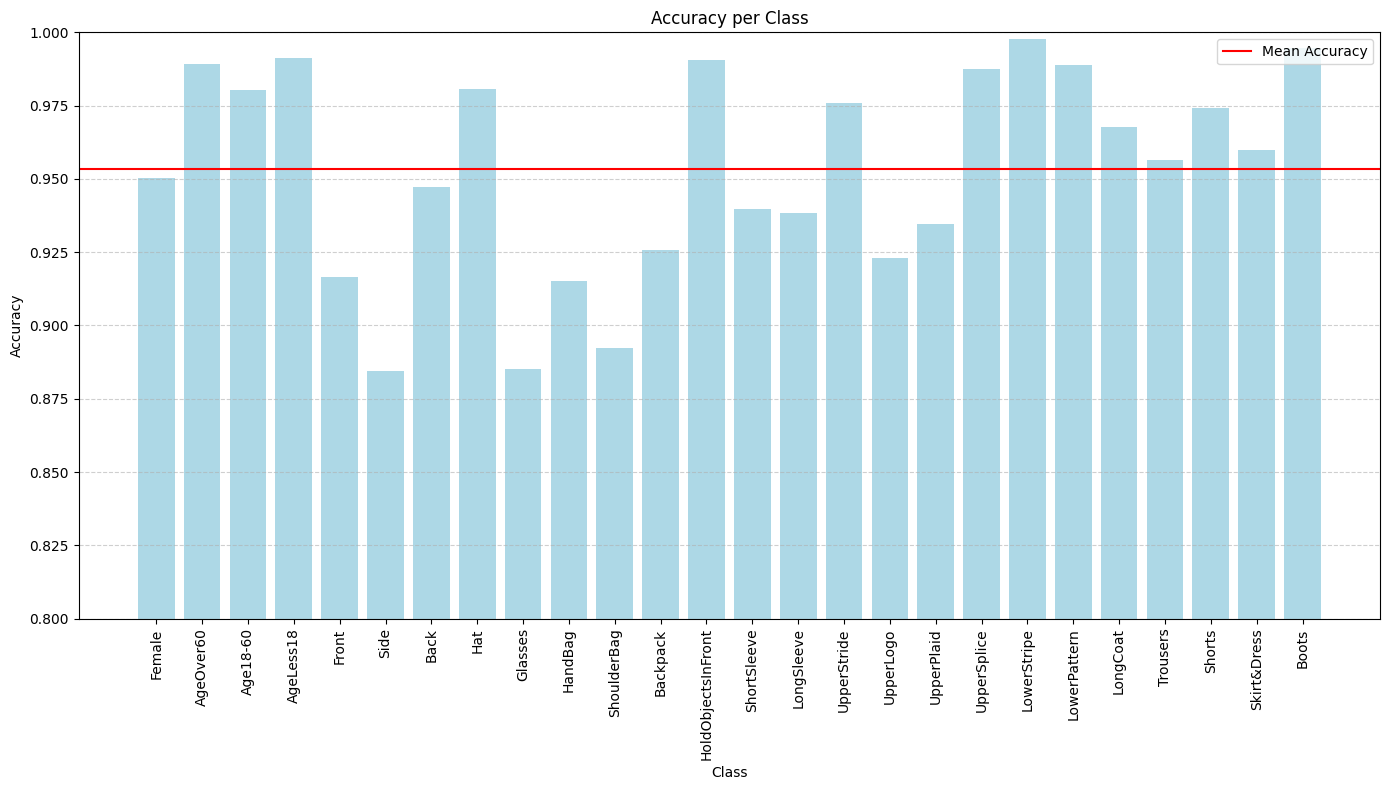

In [184]:
# Array of class names
class_names = [
    'Female', 'AgeOver60', 'Age18-60', 'AgeLess18', 'Front', 'Side', 'Back', 'Hat',
    'Glasses', 'HandBag', 'ShoulderBag', 'Backpack', 'HoldObjectsInFront', 'ShortSleeve',
    'LongSleeve', 'UpperStride', 'UpperLogo', 'UpperPlaid', 'UpperSplice', 'LowerStripe',
    'LowerPattern', 'LongCoat', 'Trousers', 'Shorts', 'Skirt&Dress', 'Boots'
]

# Calculate accuracy for each class
accuracies = np.mean(gt_labels == pred, axis=0)

# Calculating the mean accuracy
mean_accuracy = np.mean(accuracies)

plt.figure(figsize=(14, 8))
plt.bar(range(len(class_names)), accuracies, color='lightblue')
plt.axhline(y=mean_accuracy, color='r', linestyle='-', label=f'Mean Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.ylim(0.8, 1)  # Adjusting the y-axis range
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# File path to save the SVG file
file_path = './output/class_accuracy_visualization.svg'
plt.savefig(file_path, format='svg')

plt.show()


In [ ]:
import os
import shutil

def copy_images(src_folder, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for root, dirs, files in os.walk(src_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest_folder, file)
                shutil.copy2(src_file, dest_file)
                print(f"Copied {src_file} to {dest_file}")

# Example usage
src_folder = './data/PETA'
dest_folder = '/path/to/destination/folder'
copy_images(src_folder, dest_folder)